In [6]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import time
import scienceplots

import dataset
import data_Preprocess 
import models
import uLoss
import Metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ('device = ',device)
seed = 123 #seed必须是int，可以自行设置
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
plt.style.use('science')
plt.rcParams['text.usetex'] = False

device =  cuda:0


In [7]:
param = {
    'mesh_size':[0.1,0.1],
    'structure_size':[10,10],
    'measurements_num':8,
    'device':device,
    'is_plotInputMap':False,
    'Lambda':0.0,
    'HS_region':torch.tensor(([[[1.5,2.5],[6.9,8.4]],# region_1
                               [[4.4,8.4],[7.2,8.0]],# region_2
                               [[0.6,1.6],[5.0,6.0]],# region_3(1)
                               [[0.6,3.1],[4.0,5.0]],# region_3(2)
                               [[1.0,4.0],[0.8,2.8]],# region_4
                               [[5.6,8.6],[1.3,4.9]]])),# region_5
    'BCs':['Neumann','Convection','Radiation','Adiabatic&Direchlet'],# top,bottom,left,right
    'Heat Transfer Rate':52,
    'Convective coe':10,
    'Emissivity':0.05,
    'q':15,
    'T_a':20,
    'BC_regular':True,
    'HS_regular':False,
    'Direchlet BC':20,
    'learning_rate': 0.01,
    'epochs': 3000,
    'dis_interval': 500,
    'is_plotLoss':True,
    'is_plotResult':False    
    
}

In [9]:
train_set = dataset.MyDataset('Train',param)
test_set = dataset.MyDataset('Test',param)
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                          batch_size = 64,
                                          shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                          batch_size = 100,
                                          shuffle = False)
trues = data_Preprocess.get_Tfields('Test').unsqueeze(1)

In [ ]:
Unet = models.UNet(in_channels=1, out_channels=1, factors=2,param=param).to(device)
loss_fn = uLoss.UncertaintyLoss(param)
train_losses_epoch,loss_inner_epoch,loss_neumann_epoch,loss_radiation_epoch,loss_mixBC_epoch,loss_convection_epoch,loss_hsd_epoch = models._Train(Unet,train_loader,loss_fn,param)

Traing Epoch: 0, learning_rate = 0.0025
loss = 38.764370, loss_hs = 38.764370, loss_inner = 0.000244
loss component -> loss_neumann = 0.059249, loss_radiation = 0.005010, loss_convection = 0.109053, loss_mixBC = 0.046595
Traing Epoch: 500, learning_rate = 0.01
loss = 7.726479, loss_hs = 1.979431, loss_inner = 0.004438
loss component -> loss_neumann = 0.120253, loss_radiation = 0.223426, loss_convection = 1.552140, loss_mixBC = 0.230088


tensor(0.3582, grad_fn=<MeanBackward0>)
tensor(28.6575, grad_fn=<MeanBackward0>)
tensor(1123.6012, grad_fn=<MeanBackward0>)


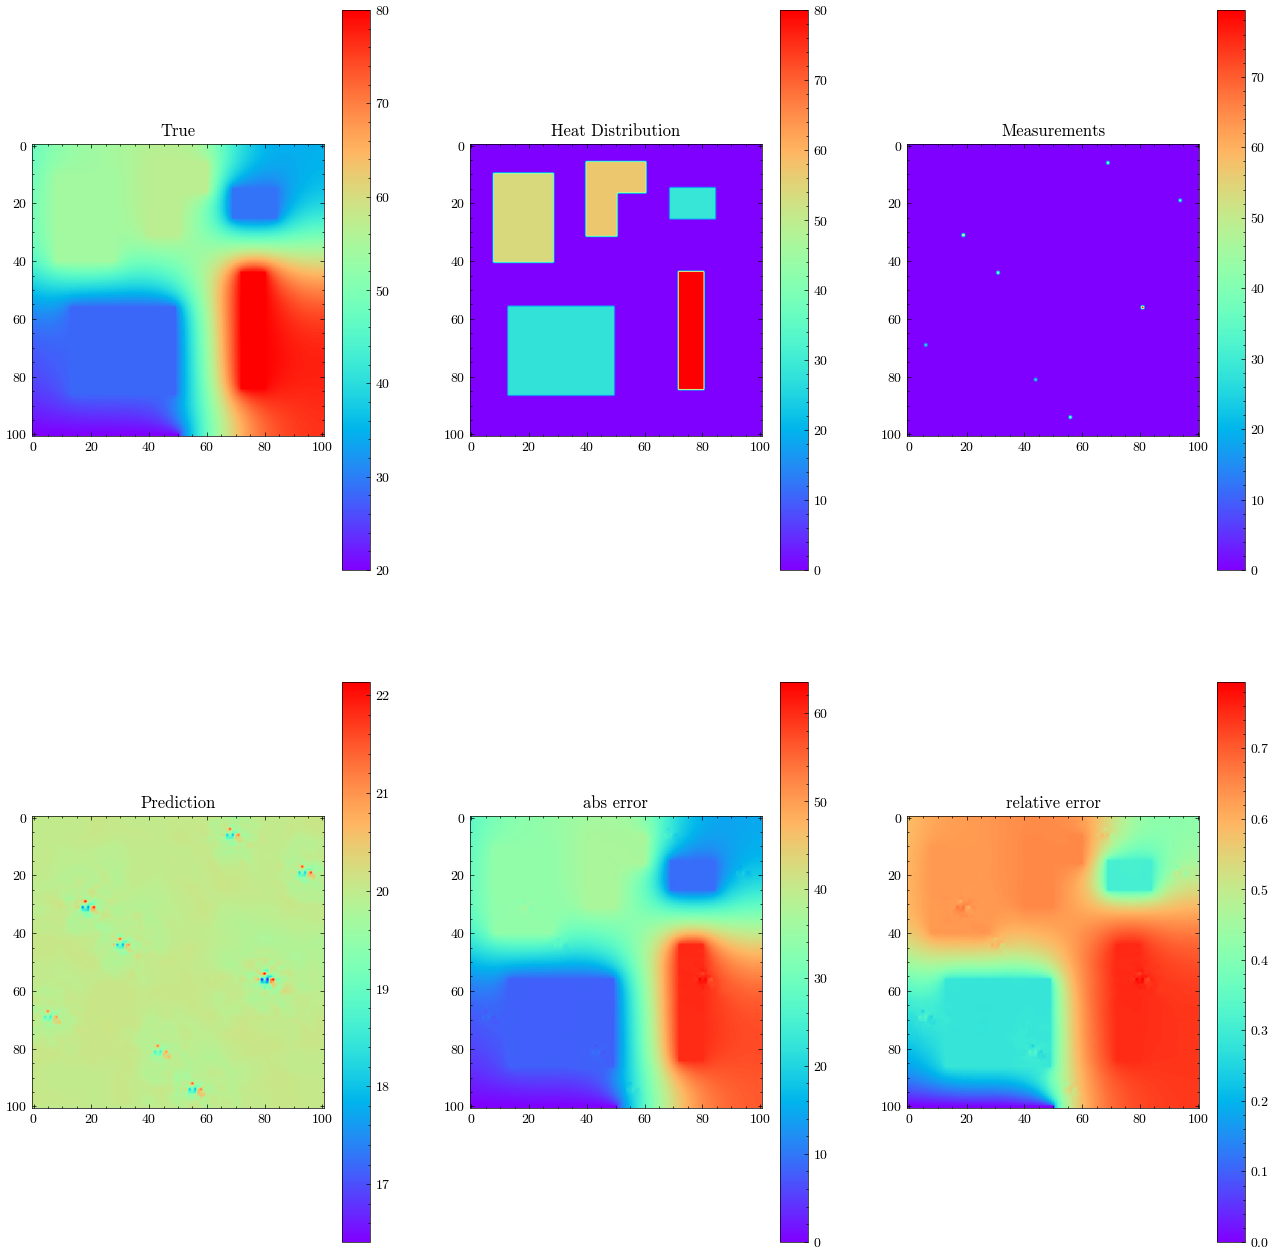

In [10]:
Unet = models.UNet(in_channels=1, out_channels=1, factors=2,param=param).to(device)
for idx,data in enumerate(test_loader):
    MP = data[0].clone().detach().requires_grad_(True)
    HSD = data[1].clone().detach().requires_grad_(True)
    break
out = Unet(MP.unsqueeze(1))
#out = uLoss.Fill_withMeasurements(out,MP,param)
#out = uLoss.HC_Convection(out,param)
out = uLoss.Fill_withDirechletBC(out,param)
label = 30
print (Metrics.ERMS(out[label][0],trues[label][0]))
print (Metrics.MAE(out[label][0].cpu(),trues[label][0].cpu()))
print (Metrics.MSE(out[label][0].cpu(),trues[label][0].cpu()))
plt.figure(figsize=(16,16))
plt.subplot(2,3,1)
plt.imshow(trues[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.title('True')
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(HSD[label].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Heat Distribution')

plt.subplot(2,3,3)
plt.imshow(MP[label].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Measurements')

plt.subplot(2,3,4)
plt.imshow(out[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Prediction')

plt.subplot(2,3,5)
plt.imshow((trues[label][0]-out[label][0].cpu()).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('abs error')

plt.subplot(2,3,6)
plt.imshow(((trues[label][0]-out[label][0].cpu())/trues[label][0]).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('relative error')
plt.show()

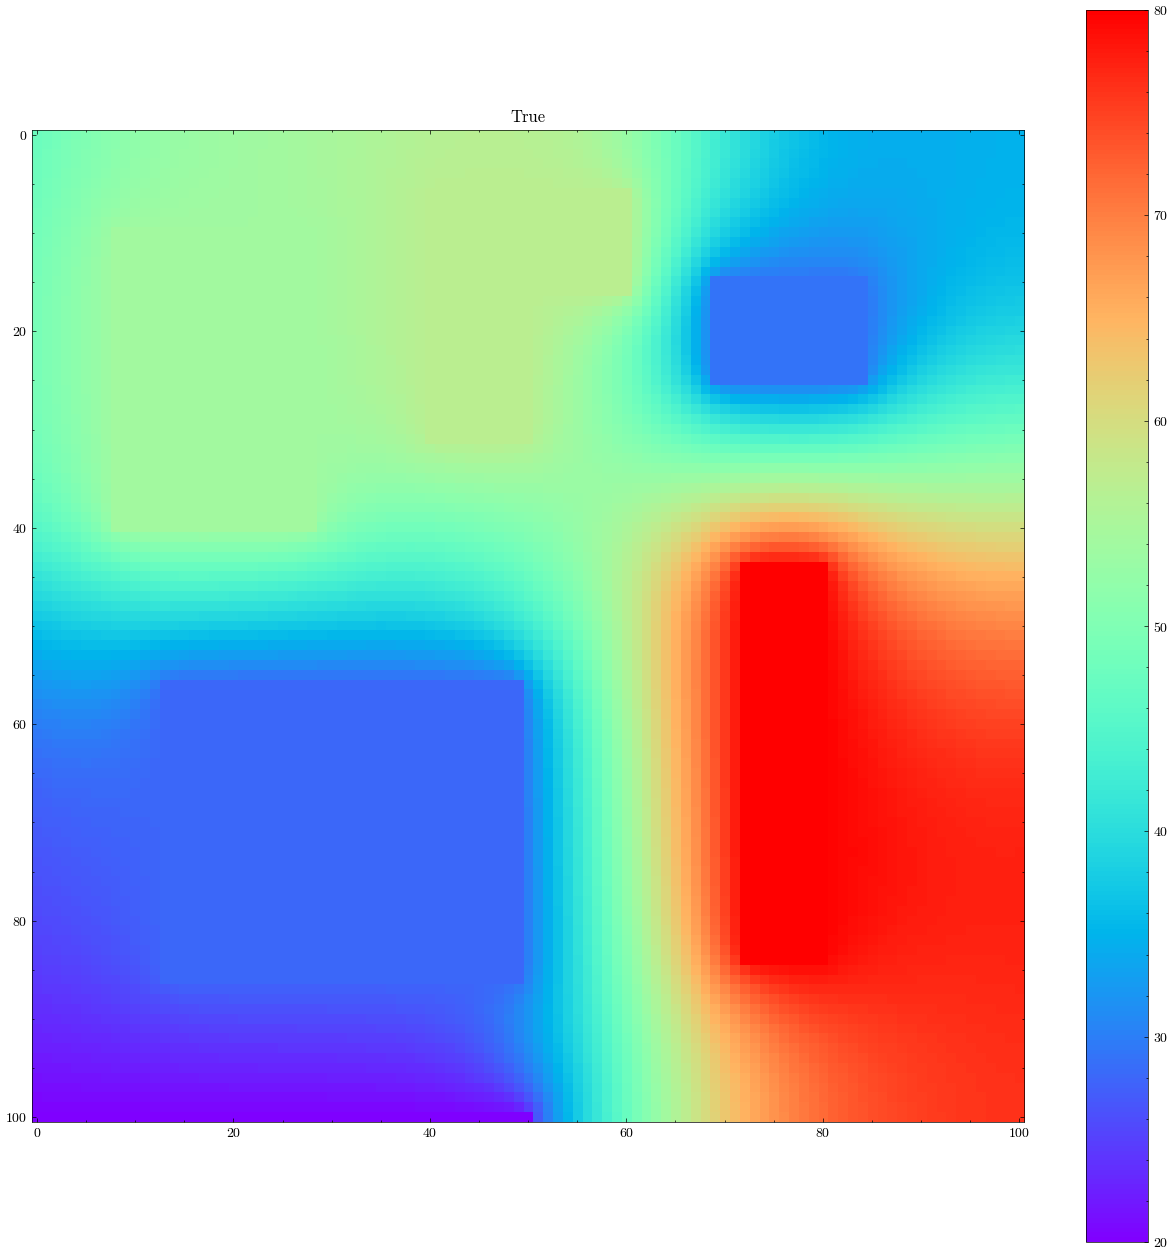

In [5]:
plt.figure(figsize=(16,16))
plt.imshow(trues[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.title('True')
plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_hsd_epoch,'-o',color='blue',label='loss_hs',linewidth=0.5,markersize=2)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_inner_epoch,'-o',color='black',label='loss_inner',linewidth=0.5,markersize=2)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_neumann_epoch,'-o',color='blue',label='loss_neumann',linewidth=0.5,markersize=2)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_radiation_epoch,'-.',color='red',label='loss_radiation',linewidth=0.5,markersize=2)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_mixBC_epoch,'-',color='green',label='loss_mixBC',linewidth=0.5,markersize=2)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_convection_epoch,'-*',color='black',label='loss_convection',linewidth=0.5,markersize=2)
plt.legend()
plt.show()


In [ ]:
print ('loss_hs = {}'.format(uLoss.loss_HSD(out,HSD,param)))
print ('loss_inner = {}'.format(uLoss.loss_T_inner(out,param)))
print ('loss_neumann = {}'.format(uLoss.loss_neumann(out,param)))
print ('loss_radiation = {}'.format(uLoss.loss_radiation(out,param)))
print ('loss_convection = {}'.format(uLoss.loss_convection(out,param)))
print ('loss_mixBC = {}'.format(uLoss.loss_mixBC(out,param)))

In [14]:
print ('loss_hs = {}'.format(uLoss.loss_HSD(trues,HSD,param)))
print ('loss_inner = {}'.format(uLoss.loss_T_inner(trues,param)))
print ('loss_neumann = {}'.format(uLoss.loss_neumann(trues,param)))
print ('loss_radiation = {}'.format(uLoss.loss_radiation(trues,param)))
print ('loss_convection = {}'.format(uLoss.loss_convection(trues,param)))
print ('loss_mixBC = {}'.format(uLoss.loss_mixBC(trues,param)))

loss_hs = 0.0
loss_inner = 0.0008430411107838154
loss_neumann = 4.6202956582419574e-05
loss_radiation = 0.0006913112592883408
loss_convection = 0.0012656645849347115
loss_mixBC = 0.005412511061877012


In [ ]:
label = 0
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(trues[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.title('True')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(HSD[label].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Heat Distribution')

plt.subplot(2,2,3)
plt.imshow(out[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Prediction')

plt.subplot(2,2,4)
plt.imshow((trues[label][0]-out[label][0].cpu()).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('abs error')
plt.show()

In [21]:
def loss_mixBC(out,param):
    hx = param['mesh_size'][0]
    hy = param['mesh_size'][1]
    MR = hy/hx
    T_ij = (2/MR**2+2)*out[:,0,-1,52:-1] - 2*out[:,0,-2,52:-1] - 1/MR**2*(out[:,0,-1,53:]+out[:,0,-1,51:-2])
    losses = torch.mean(torch.abs(T_ij))  
    if param['BC_regular'] == True:
        Reg = (out[:,0,-1,51:]-out[:,0,-2,51:])/hx
        print (Reg[0]**2)
        Reg = torch.zeros_like(Reg)
        losses = losses #+ 0.05*torch.mean(torch.exp(-75000*Reg**2))
    return  losses  
print ('loss_mixBC = {}'.format(loss_mixBC(trues,param)))

tensor([5.6316e+01, 2.2493e+01, 7.4720e+00, 3.5171e+00, 1.8894e+00, 1.1157e+00,
        7.0131e-01, 4.6096e-01, 3.1326e-01, 2.1844e-01, 1.5561e-01, 1.1292e-01,
        8.3279e-02, 6.2317e-02, 4.7296e-02, 3.6380e-02, 2.8339e-02, 2.2361e-02,
        1.7836e-02, 1.4384e-02, 1.1704e-02, 9.6039e-03, 7.9204e-03, 6.5587e-03,
        5.4429e-03, 4.5179e-03, 3.7393e-03, 3.0892e-03, 2.5394e-03, 2.0815e-03,
        1.6942e-03, 1.3692e-03, 1.1040e-03, 8.8534e-04, 7.0492e-04, 5.6299e-04,
        4.4662e-04, 3.5656e-04, 2.8558e-04, 2.2820e-04, 1.8443e-04, 1.5088e-04,
        1.2493e-04, 1.0530e-04, 9.0223e-05, 7.9001e-05, 7.0431e-05, 6.5402e-05,
        6.2354e-05, 6.1154e-05])
loss_mixBC = 0.00434362655505538


In [79]:
def loss_convection(out,param):
    hx = param['mesh_size'][0]
    hy = param['mesh_size'][1]
    coe_x = 2*hx*param['Convective coe']/param['Heat Transfer Rate']
    coe_y = 2*hy*param['Convective coe']/param['Heat Transfer Rate']
    MR = hy/hx
    f_ij = []
    Reg = []
    if param['BCs'][0] == 'Convection': # top
        T_ij = (2*MR**2+2.0+coe_y)*out[:,0,1:-1,-1] - MR**2*(out[:,0,2:,-1]+out[:,0,0:-2,-1]) - 2*out[:,0,1:-1,-2] - coe_y*param['T_a']*torch.ones_like(out[:,0,1:-1,-1])
        f_ij.append(T_ij) 
        Reg.append((out[:,0,:,-1]-out[:,0,:,-2])/hy)           
        #print ('top')
    if param['BCs'][1] == 'Convection': # bottom
        T_ij = (2*MR**2+2.0+coe_y)*out[:,0,1:-1,0] - MR**2*(out[:,0,2:,0]+out[:,0,:-2,0]) - 2*out[:,0,1:-1,1] - coe_y*param['T_a']*torch.ones_like(out[:,0,1:-1,0])
        f_ij.append(T_ij)
        Reg.append((out[:,0,:,0]-out[:,0,:,1])/hy)
        print(Reg[0][0])
        print ('bottom')
    if param['BCs'][2] == 'Convection': # left
        T_ij = (2/MR**2+2.0+coe_x)*out[:,0,0,1:-1] - (1/MR**2)*(out[:,0,0,2:]+out[:,0,0,0:-2]) - 2*out[:,0,1,1:-1] - coe_x*param['T_a']*torch.ones_like(out[:,0,0,1:-1])
        f_ij.append(T_ij)
        Reg.append((out[:,0,0,:]-out[:,0,1,:])/hx)
        #print ('left')
    if param['BCs'][3] == 'Convection': # right
        T_ij = (2/MR**2+2.0+coe_x)*out[:,0,-1,1:-1] - (1/MR**2)*(out[:,0,-1,2:]+out[:,0,-1,0:-2]) - 2*out[:,0,-2,1:-1] - coe_x*param['T_a']*torch.ones_like(out[:,0,-1,1:-1])
        f_ij.append(T_ij)
        Reg.append((out[:,0,-1,:]-out[:,0,-2,:])/hx)    
    f_ij = torch.cat(f_ij)
    Reg = torch.cat(Reg)
    losses = torch.mean(torch.abs(f_ij))
    if param['BC_regular'] == True:
        #Reg = torch.zeros_like(Reg)
        losses = losses + 0.05*torch.mean(torch.exp(-75000 * Reg**2))
    return losses   
print ('loss_convection = {}'.format(loss_convection(trues,param)))

tensor([-8.3524, -8.3680, -8.3932, -8.4312, -8.4823, -8.5461, -8.6216, -8.7059,
        -8.7948, -8.8823, -8.9622, -9.0296, -9.0819, -9.1190, -9.1432, -9.1578,
        -9.1659, -9.1698, -9.1717, -9.1724, -9.1725, -9.1725, -9.1724, -9.1725,
        -9.1727, -9.1730, -9.1737, -9.1747, -9.1756, -9.1769, -9.1782, -9.1789,
        -9.1788, -9.1766, -9.1701, -9.1561, -9.1297, -9.0844, -9.0134, -8.9111,
        -8.7756, -8.6092, -8.4194, -8.2156, -8.0077, -7.8032, -7.6070, -7.4214,
        -7.2471, -7.0841, -6.9321, -6.7905, -6.6594, -6.5385, -6.4278, -6.3273,
        -6.2367, -6.1558, -6.0840, -6.0207, -5.9649, -5.9158, -5.8724, -5.8336,
        -5.7985, -5.7663, -5.7360, -5.7071, -5.6788, -5.6504, -5.6213, -5.5909,
        -5.5583, -5.5230, -5.4840, -5.4403, -5.3908, -5.3340, -5.2684, -5.1922,
        -5.1033, -4.9994, -4.8783, -4.7381, -4.5770, -4.3941, -4.1890, -3.9625,
        -3.7160, -3.4517, -3.1719, -2.8795, -2.5771, -2.2668, -1.9508, -1.6306,
        -1.3074, -0.9821, -0.6554, -0.32

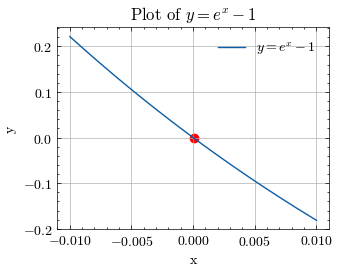

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数
def my_function(x):
    return np.exp(-20*x) - 1

# 生成 x 值
x_values = np.linspace(-0.01, 0.01, 1000)  # 生成在区间 [-0.1, 0.1] 内的 1000 个点

# 计算对应的 y 值
y_values = my_function(x_values)

# 绘制图形
plt.plot(x_values, y_values, label=r'$y = e^x - 1$')
plt.scatter([0.0001], [0.0001], color='red')  # 在 x=0.0001 处标记一个红点
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of $y = e^x - 1$')
plt.legend()
plt.grid(True)
plt.show()


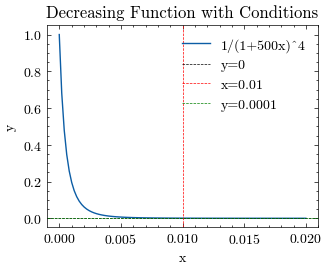

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def decreasing_function(x, k, n):
    return 1 / (1 + k * x)**n

# 生成一些示例数据
x_values = np.linspace(0, 0.02, 100)
k_value = 500  # 可以调整 k 的值
n_value = 4    # 可以调整 n 的值

# 计算函数值
y_values = decreasing_function(x_values, k_value, n_value)

# 绘制函数图像
plt.plot(x_values, y_values, label=f'1/(1+{k_value}x)^{n_value}')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--', label='y=0')
plt.axvline(0.01, color='red', linewidth=0.5, linestyle='--', label='x=0.01')
plt.axhline(0.0001, color='green', linewidth=0.5, linestyle='--', label='y=0.0001')

# 添加标签和标题
plt.title('Decreasing Function with Conditions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# 显示图形
plt.show()
